In [2]:
import HardwareSetup as HS
from pydrake.all import (
    SceneGraphCollisionChecker,
    RandomGenerator,
    MosekSolver,
    GurobiSolver,
    SaveIrisRegionsYamlFile,
)
import pydrake.planning as plan

/home/rohanbosworth/GCSClutterClearingUpdate/iiwa_setup-main/scripts/HardwareSetup.py:33: UserWarning: Could not import hardware functions
  warnings.warn("Could not import hardware functions", UserWarning)


In [2]:
diagram, context, robot, plant, internalPlantContext = HS.make_environment_model_display(hardware=False)

def get_regions():
    params = dict(edge_step_size=0.125)
    iiwa_model_instance_index = plant.GetModelInstanceByName("iiwa")
    wsg_model_instance_index = plant.GetModelInstanceByName("wsg")
    params["robot_model_instances"] = [iiwa_model_instance_index, wsg_model_instance_index]
    params["model"] = diagram
    checker = SceneGraphCollisionChecker(**params)

    options = plan.IrisFromCliqueCoverOptions()
    options.num_points_per_coverage_check = 5000
    options.num_points_per_visibility_round = 500
    options.coverage_termination_threshold = 0.7

    generator = RandomGenerator(0)

    if (MosekSolver().available() and MosekSolver().enabled()) or (
            GurobiSolver().available() and GurobiSolver().enabled()):
        # We need a MIP solver to be available to run this method.
        sets = plan.IrisInConfigurationSpaceFromCliqueCover(
            checker=checker, options=options, generator=generator,
            sets=[]
        )

        if len(sets) < 1:
            raise("No regions found")

        return sets
    else:
        print("No solvers available")

regions = get_regions()

SaveIrisRegionsYamlFile("CliqueCoverRegions.yaml", regions)

INFO:drake:Meshcat listening for connections at http://localhost:7001


RuntimeError: PackageMap::GetPackageName(): Failed to parse XML in file "/home/rohanbosworth/GCSClutterClearingDemo/iiwa_setup/scripts/../../models/package.xml".
XML_ERROR_FILE_NOT_FOUND

In [12]:
import time

gcs = GcsTrajectoryOptimization(len(q_start))
regions = gcs.AddRegions(list(iris_regions.values()), order=1)
source = gcs.AddRegions([Point(q_start)], order=0)
target = gcs.AddRegions([Point(q_end)], order=0)
edges.append(gcs.AddEdges(source, regions))
edges.append(gcs.AddEdges(regions, target))
        
gcs.AddPathLengthCost()
gcs.AddTimeCost(weight = 0.2)

options = GraphOfConvexSetsOptions()
options.preprocessing = True
options.max_rounded_paths = 5
start_time = time.time()
print("Running GCS")
traj, result = gcs.SolvePath(source, target, options)
print(f"GCS solved in {time.time() - start_time} seconds")

INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 5 rounding trials.


Running GCS
GCS solved in 2.7190096378326416 seconds


In [6]:
import HardwareSetup as HS
from pydrake.all import (
    SceneGraphCollisionChecker,
    RandomGenerator,
    MosekSolver,
    GurobiSolver,
    SaveIrisRegionsYamlFile,
)
import pydrake.planning as plan

plant, robot_model_instances, diagram = HS.LoadRobotIRIS()

def get_regions():
    params = dict(edge_step_size=0.125)
    iiwa_model_instance_index = plant.GetModelInstanceByName("iiwa")
    wsg_model_instance_index = plant.GetModelInstanceByName("wsg")
    params["robot_model_instances"] = robot_model_instances
    params["model"] = diagram
    checker = SceneGraphCollisionChecker(**params)

    options = plan.IrisFromCliqueCoverOptions()
    options.num_points_per_coverage_check = 5000
    options.num_points_per_visibility_round = 500
    options.coverage_termination_threshold = 0.8

    generator = RandomGenerator()

    sets = plan.IrisInConfigurationSpaceFromCliqueCover(
            checker=checker, options=options, generator=generator,
            sets=[]
    )

    if len(sets) < 1:
        raise("No regions found")

    
    return sets

regions = get_regions()
regions_dict = {str(i): region for i, region in enumerate(regions)}

SaveIrisRegionsYamlFile("CliqueCoverRegions.yaml", regions_dict)

INFO:drake:Allocating contexts to support implicit context parallelism 20
INFO:drake:Using default max clique solver MaxCliqueSolverViaGreedy.
INFO:drake:Current Fraction of Domain Covered = 0
INFO:drake:IrisFromCliqueCover Iteration 1/100


file:///home/rohanbosworth/GCSClutterClearingUpdate/iiwa_setup-main/scripts/bin.sdf
/home/rohanbosworth/GCSClutterClearingUpdate/iiwa_setup-main/scripts/bin.sdf


INFO:drake:Clique added to queue. There are 146/500 points left to cover.
INFO:drake:Clique added to queue. There are 114/500 points left to cover.
INFO:drake:Clique added to queue. There are 90/500 points left to cover.
INFO:drake:Clique added to queue. There are 68/500 points left to cover.
INFO:drake:Clique added to queue. There are 41/500 points left to cover.
INFO:drake:Clique added to queue. There are 27/500 points left to cover.
INFO:drake:Clique added to queue. There are 11/500 points left to cover.
INFO:drake:Clique added to queue. There are 3/500 points left to cover.
INFO:drake:Finished adding cliques. Total of 8 clique added. Number of cliques left to process = 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurati

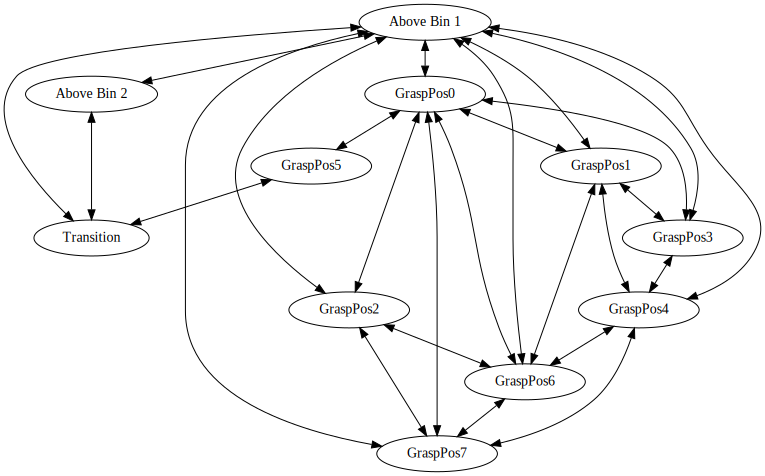

26


In [20]:
import pydot
from IPython.display import SVG, display

def VisualizeConnectivity(iris_regions):
    numEdges = 0

    graph = pydot.Dot("IRIS region connectivity")
    keys = list(iris_regions.keys())
    for k in keys:
        graph.add_node(pydot.Node(k))
    for i in range(len(keys)):
        v1 = iris_regions[keys[i]]
        for j in range(i + 1, len(keys)):
            v2 = iris_regions[keys[j]]
            if v1.IntersectsWith(v2):
                numEdges += 1
                graph.add_edge(pydot.Edge(keys[i], keys[j], dir="both"))
    display(SVG(graph.create_svg()))
    return numEdges
    
print(VisualizeConnectivity(iris_regions))


In [23]:
import numpy as np
from pydrake.all import *
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    Parser,
    RigidTransform,
    RotationMatrix,
)
from manipulation.station import MakeHardwareStation
from manipulation.scenarios import AddRgbdSensors, ycb
from manipulation.utils import ConfigureParser
from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix
from pydrake.multibody.inverse_kinematics import InverseKinematics
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph

from pydrake.multibody.tree import Body
from pydrake.solvers import Solve
from pydrake.systems.framework import DiagramBuilder

from manipulation.station import load_scenario, LoadScenario, AddPointClouds, AppendDirectives

from manipulation import FindResource

import warnings

from pydrake.all import DiagramBuilder
from pydrake.all import StartMeshcat
def make_environment_model_sim(
     TrajPosOut = None, WSGOut = None, GraspSelector = None, AntipHandler = None
):
    # Make one model of the environment, but the robot only gets to see the sensor outputs.

    builder = DiagramBuilder()

    mesh = StartMeshcat()
    
    obj = None

        
    model_directives = (
        """    
directives:

- add_model:
    name: bin0
    file: file:///home/rohanbosworth/manipulation/manipulation/models/hydro/bin.sdf

- add_weld:
    parent: world
    child: bin0::bin_base
    X_PC:
      rotation: !Rpy { deg: [0.0, 0.0, 90.0 ]}
      translation: [-0.05, -0.5, -0.015]

- add_model:
    name: bin1
    file: file:///home/rohanbosworth/manipulation/manipulation/models/hydro/bin.sdf

- add_weld:
    parent: world
    child: bin1::bin_base
    X_PC:
      rotation: !Rpy { deg: [0.0, 0.0, 180.0 ]}
      translation: [0.5, 0.05, -0.015]

- add_model:
    name: floor
    file: file:///home/rohanbosworth/manipulation/manipulation/models/floor.sdf

- add_weld:
    parent: world
    child: floor::box
    X_PC:
        translation: [0, 0, -.5]

# Add iiwa
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.8]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1]
        iiwa_joint_7: [1.57]

- add_weld:
    parent: world
    child: iiwa::base

# Add schunk
- add_model:
    name: wsg
    file: package://drake_models/wsg_50_description/sdf/schunk_wsg_50_welded_fingers.sdf

- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
      translation: [0, 0, 0.114]
      rotation: !Rpy { deg: [90.0, 0.0, 0.0 ]}

- add_model:
    name: foam_brick1
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [-0.17, -0.6, 0.05]
- add_model:
    name: foam_brick2
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [-0.18, -0.5, 0.05]
                
- add_model:
    name: meatCan
    file: package://manipulation/hydro/010_potted_meat_can.sdf
    default_free_body_pose:
        base_link_meat:
            translation: [-0.05, -0.45, 0.05]
                
- add_model:
    name: pickObject
    file: package://manipulation/hydro/004_sugar_box.sdf
    default_free_body_pose:
        base_link_sugar:
            translation: [0.05, -0.55, 0.05]
            rotation: !Rpy { deg: [0.0, 90.0, 0.0 ]}
    """)

    builder = DiagramBuilder()

    scenario = LoadScenario(data=model_directives    )
    '''
    station: IiwaHardwareStationDiagram = builder.AddNamedSystem(
        "station",
        IiwaHardwareStationDiagram(
            scenario=scenario, has_wsg=True, use_hardware=False
        ),
    )
    '''

    station = builder.AddSystem(MakeHardwareStation(scenario, mesh))

    
    plant = station.GetSubsystemByName("plant")
        
    robot = plant.GetModelInstanceByName("iiwa")

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    
        
    return diagram, context, robot, plant, mesh


diagram, context, robot, plant, mesh = make_environment_model_sim()

plant.SetPositions(plant.GetMyContextFromRoot(context), robot,[-1.58421952  ,0.54952898 , 0.05656403 ,-1.6807761  , 0.10612069 , 0.90203368,
  1.55806721])

diagram.ForcedPublish(context)
mesh.Flush()

INFO:drake:Meshcat listening for connections at http://localhost:7003


In [44]:
for key, reg in iris_regions.items():
    if reg.PointInSet([-2.27218173, 0.37183194, 0.6459329, -1.86001069, -0.26713113, 0.97730485, 0.1065661]):
        print(key)

In [23]:
iris_regions = dict()
iris_regions.update(LoadIrisRegionsYamlFile("my_iris.yaml"))
for key, reg in iris_regions.items():
    if reg.PointInSet([-1.87802498  ,0.78751608 , 0.63640613, -1.40317655, -0.49504055 , 1.11240971,
 -1.15365824]):
        print(key)

GraspPos3


In [22]:
iris_regions = dict()
iris_regions.update(LoadIrisRegionsYamlFile("my_iris.yaml"))
for key, reg in iris_regions.items():
    if reg.IntersectsWith(iris_regions['GraspPos3']):
        print(key)

Above Bin 2
Between Bins
GraspPos0
GraspPos14
GraspPos2
GraspPos25
GraspPos26
GraspPos27
GraspPos3
GraspPos6


In [22]:
from pydrake.geometry.optimization import (
    HPolyhedron,
    IrisInConfigurationSpace,
    IrisOptions,
    LoadIrisRegionsYamlFile,
    SaveIrisRegionsYamlFile,
)
from pydrake.solvers import MathematicalProgram, Solve
import multiprocessing as mp
import HardwareSetup as HS
import time

# TODO(russt): fetch the an existing yaml using urlretrieve

iris_options = IrisOptions()
iris_options.iteration_limit = 10
# increase num_collision_infeasible_samples to improve the (probabilistic)
# certificate of having no collisions.
iris_options.num_collision_infeasible_samples = 3
iris_options.require_sample_point_is_contained = True
iris_options.relative_termination_threshold = 0.01
iris_options.termination_threshold = -1

seeds = dict()

seeds["ZeroedPosition"] = [0, 0, 0, 0, 0, 0, 0]
seeds["Above Bin 2"] = [0, 0.3, 0, -1.8, 0, 1, 1.57]
seeds["Deposit Pos 2"] = [-0.262, 0.3, 0, -1.8, 0, 1, (1.57)]
seeds["Deposit Pos 2 Up"] = [-0.262, 0.0, 0, -1.8, 0, 1, (1.57)]

seeds["In Bin 2"] = [0, 0.48, 0, -1.88, 0, 0.67, 1.57]
seeds["In Bin 1"] = [-1.56, 0.62, 0, -1.74, 0, 0.67, 1.57]
seeds["Above Bin 1"] = [-1.57, 0.3, 0, -1.8, 0, 1, 1.57]
seeds["Transition"] = [-0.75, -0.61, 0, -1.8, 0, 1, 1.57]

seeds["Between Bins"] = [-0.785, 0.2, 0, -1.8, 0, 1, 1.57]  

# Additional options for this notebook:

# If use_existing_regions_as_obstacles is True, then iris_regions will be
# shrunk by regions_as_obstacles_margin, and then passed to
# iris_options.configuration_obstacles.
use_existing_regions_as_obstacles = True
regions_as_obstacles_scale_factor = 0.95

# We can compute some regions in parallel.
num_parallel = mp.cpu_count()

def ScaleHPolyhedron(hpoly, scale_factor):
    # Shift to the center.
    xc = hpoly.ChebyshevCenter()
    A = hpoly.A()
    b = hpoly.b() - A @ xc
    # Scale
    b = scale_factor * b
    # Shift back
    b = b + A @ xc
    return HPolyhedron(A, b)


def _CheckNonEmpty(region):
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(region.ambient_dimension())
    region.AddPointInSetConstraints(prog, x)
    result = Solve(prog)
    assert result.is_success()


def _CalcRegion(name, seed):
    plant, diagram = HS.LoadRobotIRISSeeds()
    robot = plant.GetModelInstanceByName("iiwa")
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    plant.SetPositions(plant_context, robot, seed)
    currPos = plant.GetPositions(plant_context)
    print(currPos)

    diagram.ForcedPublish(diagram_context)

    if use_existing_regions_as_obstacles:
        iris_options.configuration_obstacles = [
            ScaleHPolyhedron(r, regions_as_obstacles_scale_factor)
            for k, r in iris_regions.items()
            if k != name
        ]
        for h in iris_options.configuration_obstacles:
            _CheckNonEmpty(h)
    else:
        iris_options.configuration_obstacles = []
    display(f"Computing region for seed: {name}")
    start_time = time.time()

    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    display(
        f"Finished seed {name}; Computation time: {(time.time() - start_time):.2f} seconds"
    )

    _CheckNonEmpty(hpoly)
    reduced = hpoly.ReduceInequalities()
    _CheckNonEmpty(reduced)

    return reduced

iris_filename = "my_irisSim.yaml"

def GenerateRegion(name, seed):
    global iris_regions
    region = _CalcRegion(name, seed)
    iris_regions[name] = _CalcRegion(name, seed)
    SaveIrisRegionsYamlFile(f"{iris_filename}.autosave", iris_regions)

iris_regions = dict()
iris_regions.update(LoadIrisRegionsYamlFile(iris_filename))

regName = "GraspPos7"

if regName not in iris_regions.keys():
    GenerateRegion(regName, [-1.58421952  ,0.54952898 , 0.05656403 ,-1.6807761  , 0.10612069 , 0.90203368,
  1.55806721])
else:
    print("Region already exists")



Region already exists


In [21]:
SaveIrisRegionsYamlFile(iris_filename, iris_regions)

In [17]:
print(iris_regions.keys())

dict_keys(['Above Bin 1', 'Above Bin 2', 'GraspPos0', 'GraspPos1', 'GraspPos2', 'GraspPos3', 'GraspPos4', 'GraspPos5', 'Transition', 'GraspPos6'])
